In [1]:
# Chaitra Pirisingula
# Shruti Pradeep
# 04/10/2023 

In [2]:
from ColorBlindnessAnalysis import simulate_colorblindness, get_colors, get_color_similarity_scores, display_charts
import numpy as np
import cv2

In [3]:
# This matrix simulates protanopia, one of the most common forms of color blindness
protanopia_simulation_matrix = np.array([[0.567, 0.433, 0],
                                [0.558, 0.442, 0],
                                [0, 0.242, 0.758]])

# This matrix simulates deuteranopia, another common form of color blindness
deuteranopia_simulation_matrix = np.array([[0.625, 0.375, 0],
                                [0.7, 0.3, 0],
                                [0, 0.3, 0.7]])

# This matrix simulates tritanopia, a rare form of color blindness
tritanopia_simulation_matrix = np.array([[0.95, 0.05, 0],
                                [0, 0.433, 0.567],
                                [0, 0.475, 0.525]])

cb_masks = [protanopia_simulation_matrix, deuteranopia_simulation_matrix, tritanopia_simulation_matrix]
cb_names = ["Protanopia", "Deuteranopia", "Tritanopia"]

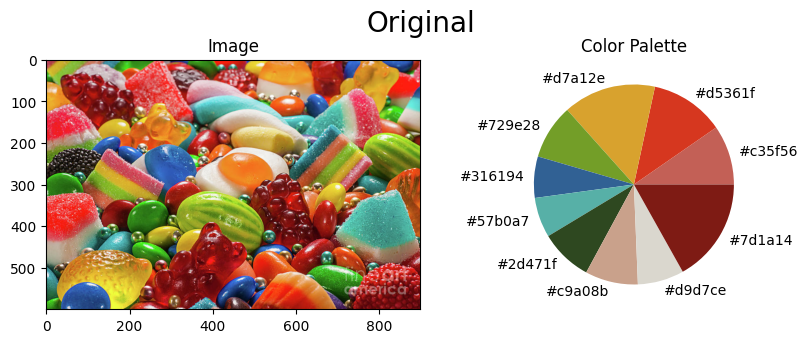

In [4]:
# Load original image
image = cv2.imread('images/candy.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Get original colors and corresponding colorblindness colors with delta e scores
original_colors = get_colors(image, 10, "Original")
cb_scores = get_color_similarity_scores(original_colors, cb_names, cb_masks)

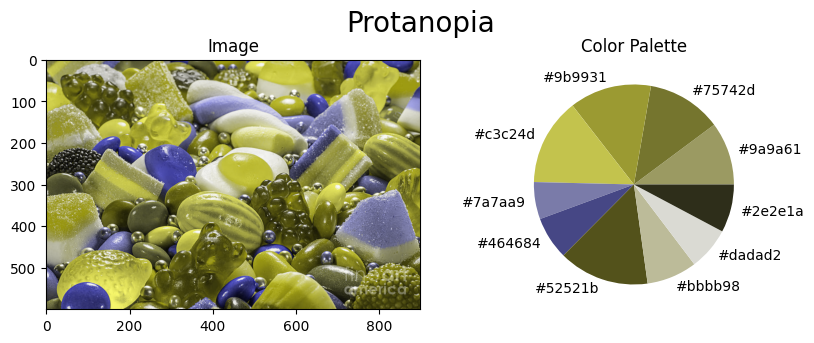

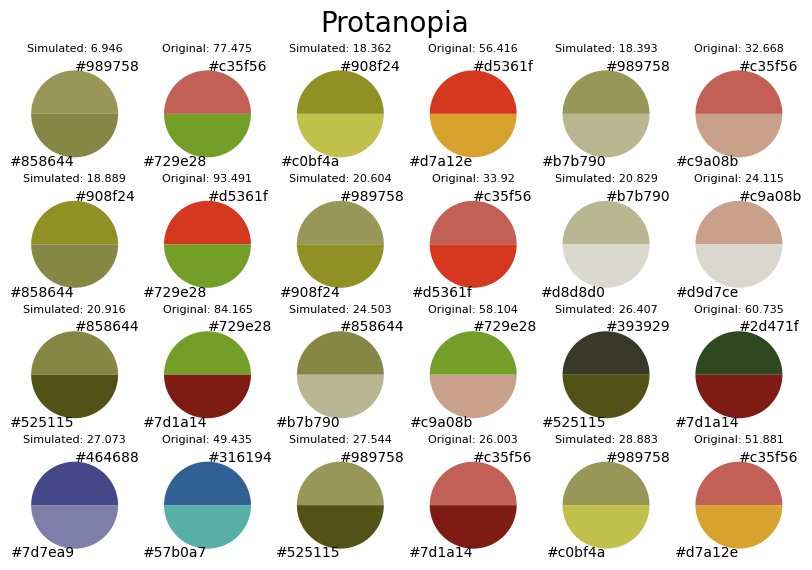

In [5]:
# Simulate Protanopia and display results 
protanopia_image = simulate_colorblindness(protanopia_simulation_matrix, image)
protanopia_colors = get_colors(protanopia_image, 10, cb_names[0])
display_charts(cb_names[0], cb_scores[cb_names[0]])

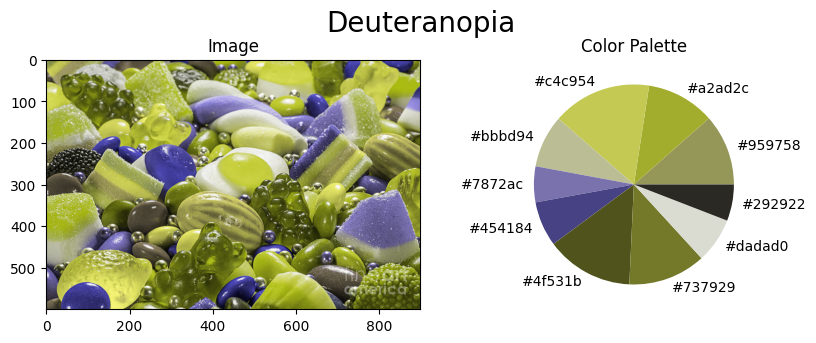

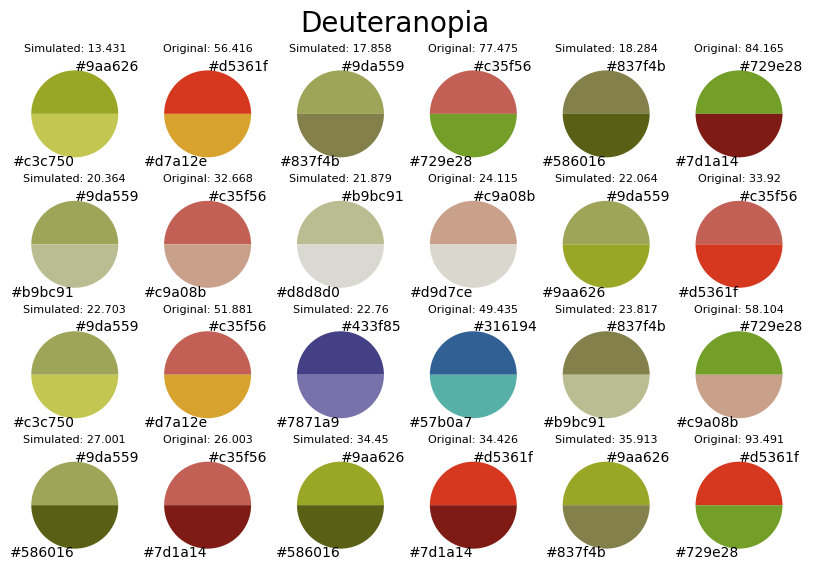

In [6]:
# Simulate Deuteranopia and display results 
deuteranopia_image = simulate_colorblindness(deuteranopia_simulation_matrix, image)
deuteranopia_colors = get_colors(deuteranopia_image, 10, cb_names[1])
display_charts(cb_names[1], cb_scores[cb_names[1]])

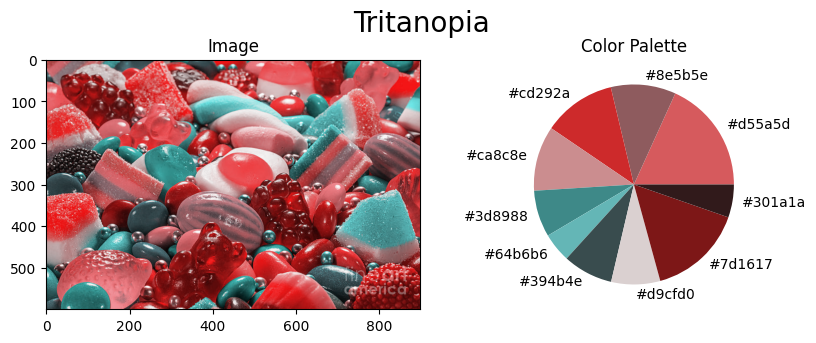

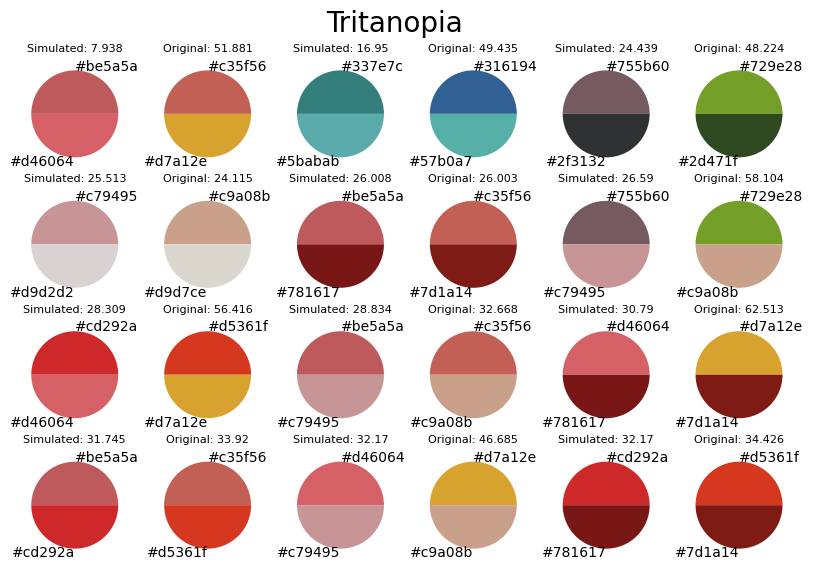

In [7]:
# Simulate Tritanopia and display results 
tritanopia_image = simulate_colorblindness(tritanopia_simulation_matrix, image)
tritanopia_colors = get_colors(tritanopia_image, 10, cb_names[2])
display_charts(cb_names[2], cb_scores[cb_names[2]])